In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

FC_N = 36               # forecast periods
FC_STRIDE = 10
FC_START = "19590101"   # period at which to split training and validation dataset




EPOCH = 300       # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

/home/sairam/projects/evv2gfcr/rnnvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/home/sairam/projects/evv2gfcr/evv2gfcr/FrequencyGenerator/FrequencyData/FrequencyData.csv', index_col=0)
print(df)



                     Frequency
2020-01-01 00:00:00  50.000233
2020-01-01 00:00:01  50.025000
2020-01-01 00:00:02  50.024000
2020-01-01 00:00:03  50.023000
2020-01-01 00:00:04  50.022000
...                        ...
2020-01-31 23:59:55  50.041000
2020-01-31 23:59:56  50.039000
2020-01-31 23:59:57  50.037000
2020-01-31 23:59:58  50.035000
2020-01-31 23:59:59  50.034000

[2678400 rows x 1 columns]


In [3]:
df.describe()

,Frequency
count,2.678400e+06
mean,5.000023e+01
std,1.839557e-02
min,4.988500e+01
25%,4.998900e+01
50%,5.000023e+01
75%,5.001200e+01
max,5.015800e+01


<Axes: >

<Figure size 1200x500 with 0 Axes>

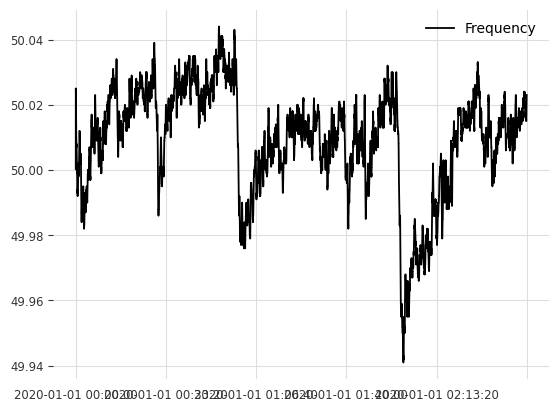

In [4]:

plt.figure(100, figsize=(12,5))
df_subset = df.iloc[:10000]
df_subset.plot()



In [5]:
from darts import TimeSeries
# analyze its seasonality

# Assuming your DataFrame is named 'df' and the datetime column is named 'datetime'
df.index = pd.to_datetime(df.index)
ts = TimeSeries.from_dataframe(df)

#is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
#dict_seas ={
#    "is seasonal?":is_seasonal, 
#    "periodicity (months)":f'{periodicity:.1f}', 
#    "periodicity (~years)": f'{periodicity/12:.1f}'}
#_ = [print(k,":",v) for k,v in dict_seas.items()]

In [6]:
#plot_acf(ts, periodicity, max_lag=150)

In [7]:
FC_START = "20200120"
# Splitting TimeSeries
train, val = ts.split_after(pd.Timestamp(FC_START))


In [ ]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))